### 输入数据展示

In [1]:
import pandas as pd

################## 读取数据 ##################
# 读取的数据为下面服务
# 外界输入的量

energy_MYbaseline18502100_biomass = [63.34] # 初始条件,参照原文中写法


CO2emission_baseline18502100_LU_input = pd.read_csv("input/output_CO2emission_baseline18502100_LU.csv") # 计算 Co2_actual 进而计算 co2_net, 然后在 ssm 中的 dC_a_dt 使用
# 读取 CO2emission_baseline18502100_LU.csv 文件中的 value 列的数据储存为列表
CO2emission_baseline18502100_LU = CO2emission_baseline18502100_LU_input['Value'].values.tolist()

additionalforcing_input = pd.read_csv("input/output_nonco2_forcing_all_BAU.CSV")   # 计算 NSM 中的 dT_a_dt 使用，
additionalforcing = additionalforcing_input['Value'].values.tolist()

# 基准线计算的部分
energy_MYbaseline18502100_total_input =  pd.read_csv("input/output_energy_MYbaseline18502100_total_formulated.csv")
energy_MYbaseline18502100_total = energy_MYbaseline18502100_total_input['Value'].values.tolist()

#is the only real data input to the model, not FF/biomass/renewable break up of energy
# 这是里面关键的一个量，后面的计算都是基于这个量进行的
GDP_formulated_input = pd.read_csv("input/output_GDP_SSP5_this study.csv")  # GDP 是后面计算的关键，gammarACE3 计算需要
GDP_formulated = GDP_formulated_input['Value'].values.tolist()




## v6
- 重点考虑绘制的部分，
- 参照于原作者中的代码相关工作


In [2]:
# 版本修改内容：
# 1. 替换其中的 [time-model_init_year]


################## 基本参数加载部分##################
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy.io
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile

# # # # # # # #  set parameters  # # # # # # #  
    
CO2eff=5.35 #6.3 # W/m2 of 2*CO2

mat=1.8e20 # number of moles in the atm
rho_a=1e6/mat/12*1e15 #conversion factor from Pg (or Gt) to ppm

lamb=   1/ 0.8 # 3.8/4    #Climate feedback parameters(Wm-2/ K)

deltaT = 3.156e7  # seconds in a yearaddtionalforcing
H = 997 * 4187 * 300  # heat capacity of global ocean (300 m in depth)

# note that #H/deltaT-kappa_l = ~40
kappa_l=   20  # Land surface heat capacity (Wm-2)/(K/yr), note that the unit is convert to yr, not sec
kappa_o=  20  # H/deltaT-kappa_l # Ocean surface heat capacity 

Do = 0.4 # heat diffusion coefficient from atm to ocean
# I change this from kdeep to Do, the table is wrong

# the following are related to carbon cycle

c_amp=1.1 #carbon feedback amplification factor

beta_l= 0.25 #Biosphere carbon fertilization parameter (Pg/ppm)
beta_o=  0.2  #Ocean carbon diffusion parameter(Pg/ppm)
beta_od=0.25 #Deep shallow ocean carbon diffusion coefficient(Pg/ppm)

gamma_l=  -0.13 #Biosphere temperature response(Pg/K)
gamma_o=  -0.2 #Ocean carbon solubility response(Pg/K)


aco2c = 280  # atmospheric co2 concentration in ppm
cina = aco2c/rho_a  # carbon in atm ; ppm -> Pg

oco2c = aco2c  # the ocean is in balance with atm
cino = 100     # the carbon stock in ocean; this is an assumption to be verfied
rho_o=oco2c/cino  #  rho is to convert Pg to ppm

odco2c = aco2c # the deep ocean is in balance with atm 
cinod = 1000 # the carbon stock in ocean; this is an assumption to be verified
rho_od= odco2c/cinod


# 设置年份的时间关键
model_init_year = 1850  
model_end_year = 2100  

time = np.array(range(model_init_year,model_end_year+1), dtype=int)  # 1850 to 2101

# in our model
# "future" starts from 2016. 
# "historical" ends in 2015.

print(time)


################## 函数部分 ##################

#### the IEM formulation 
# 定义 all the global variables

#############################################

# 定义时间量技术
t_count_lx = []


conversionfactor_FF_high = 77.942 / (44 / 12 * 1000) # 根据原始的代码部分获取的:conversionfactor_FF_low = np.min...
conversionfactor_FF_low = 71.964 / (44 / 12 * 1000) 


# 定义 Co2 变量
CO2emission_actual = []
CO2emission_net = []

CO2emission_actualFF = [] # 开始不影响，只影响 CH4 模式
CO2emission_actualbiomass = [] # 没有用到

CO2emission_addl_B3B_FF = [] # B3B 部分暂时也不考虑
CO2emission_addl_B3B_FF_injustice = [] # TODO B3B 部分后续要删除

CO2emission_addl_ACE3_FF = [] # 单独计算定义部分，可以考虑删除更新
CO2emission_addl_ACE3_FF_injustice = []

# CO2emission_addl_enhance = [] # 删去，不考虑
CO2emission_ACE1 = []
CO2emission_ACE2 = []
CO2emission_ACE3 = []

# CO2emission_betaACE3 = [] # 暂时没有什么用，没有被调用

# 定义能量变量
energy_MYadjusted18502100_total = [] # 真正变化的影响数值
energy_MYadjusted18502100_total_plus_B3B = [] # 受到 energy_addl_B3B，但是数值为 0 
energy_MYadjusted18502100_total_plus_B3B_plus_ACE3 = [] # 很多量，关键的部分
energy_addl_ACE3 = [] # 很多量，关键的部分，影响最终整体的 energy 

energy_addl_B3B_EnhanceRatio = [] # 暂时不考虑，对应计算值是 0


# # 甲烷相关量，复杂模式计算才需要一般是不用的
# Emission_CH4_actual = []
# Emission_CH4_coupling_actual = []
# FC_CH4 = []

# SSM 中各变量中的参数
# E21- Renewable using current technology (Solar and Wind)
k21 = []
tao21= []

taoR21 = []
taoP21 = []

taoDV21 = []
taoDF21 = []

eta21 = [] # start up 的计算部分
# E22: Renewable Using New Technology
k22 = []
tao22 = []

taoR22 = []
taoP22 = []

taoDV22 = []
taoDF22 = []

eta22 = [] # start up 的计算部分


# 其他相关量
ratio_net_over_gross = []

time_ode = [] # 用来记录当前 ode 求解下的时间序列长度，需要使用全局变量

# 补充记录数值使用，lx 辅助添加的
E11_all = []


def IEM(y, t):      #, kappa_l,Do,gamma_l,gamma_o,c_amp,rho_a,beta_l,beta_o,lamb,rho_o,rho_od,beta_od,kappa_o

    t
    t_count_lx.append(t)  # 记录当前时间序列
    time_ode.append(t)  # 记录当前时间序列
    
    T_a,C_a,C_o,C_od,T_o, E21, E22, E23, E24, E12 = y

    ################## 插值处理离散变为连续部分 ##################
    # 通过插值处理，将离散的数据变为连续的数据
    CO2emission_baseline18502100_LU_t = np.interp(t, time, CO2emission_baseline18502100_LU)
    additionalforcing_t = np.interp(t, time, additionalforcing)
    energy_MYbaseline18502100_total_t = np.interp(t, time, energy_MYbaseline18502100_total)
    GDP_formulated_t = np.interp(t, time, GDP_formulated)
    
    
    # 计算其中的碳密度部分，这是个动态的过程
    # TODO 可以考虑暂定一个值
    if (T_a < 1):
        conversionfactor_FF= conversionfactor_FF_high
    elif (T_a < 2):
        conversionfactor_FF= conversionfactor_FF_high - (conversionfactor_FF_high-conversionfactor_FF_low)/1*(T_a-1)
    else:
        conversionfactor_FF= conversionfactor_FF_low
        

        
    # energy intensity
    # 文中的公式有表示
    if (t<2015):
        re = 1
    else:
        re =  np.exp(-0.005*(1+T_a**1)*(t-2016))/np.exp(-0.005*(t-2016)) # 表示对温度敏感
        #re =   np.exp(-0.005*(T_a**1)*(time-2016))
        #re =   np.exp(-0.005*(T_a-1))
        #re = 1 # case 10, without energy efficienty
        if (re < 0.7):
            re = 0.7
        
            
        
    # 不考虑 B3B 部分
    # # approach 0; not considering the Bottom Trillions
    # energy_addl_B3B_EnhanceRatio.append(float(0))
            
     
    # calculate the total energy demand, from the baseline
    # June 24, 2021, now using th formulated energy from GDP
        
    # 注意时间调节顺序，先调节能源强度，再调节能源总量，这才是最新的
    # energy_MYadjusted18502100_total.append(energy_MYbaseline18502100_total[int(t)-model_init_year] * re) # accounting for re  # 每年因为灵活调节而在 baseline 上的调整
    # 更改为连续的计算方式
    energy_MYadjusted18502100_total.append(energy_MYbaseline18502100_total_t * re) # accounting for re  # 每年因为灵活调节而在 baseline 上的调整
        
    # energy_addl_B3B=energy_MYbaseline18502100_total[int(time)-model_init_year]*energy_addl_B3B_EnhanceRatio[-1]      # additional energy due to B3B
    # energy_MYadjusted18502100_total_plus_B3B.append(energy_MYadjusted18502100_total[int(time)-model_init_year]+energy_addl_B3B)  # including B3B but not ACE3
    # energy_MYadjusted18502100_total_plus_B3B.append(energy_MYadjusted18502100_total[int(time)-model_init_year])  # 由于 0值，所以默认的是相等的
    energy_MYadjusted18502100_total_plus_B3B.append(energy_MYadjusted18502100_total[-1])  # 由于 0值，所以默认的是相等的, 列表序列值进行了更改
  
        
    ### Aug 21 ACE   ###
    # TODO ACE 函数子模块打包进行计算得到
    ACE3_annualcap = 20.0   # set to 20 or 50

    # 这是基于上面计算调整后的
    E11dummy = energy_MYadjusted18502100_total_plus_B3B[-1]- E12 - E21 - E22 - E23 - E24         # in this model set up, E terms are absoluate values
    
    if (E11dummy<0):
        E11dummy=0  # net/gross
        
    E11fractiondummy = E11dummy/energy_MYadjusted18502100_total_plus_B3B[-1] # 这是基于调整后的计算，计算的基准线不同

    E11fraction_ACE3 = E11fractiondummy  # YOU CAN change this 1 to assume ACE3 to use  FF only，简化得到相关数值
    
    # if (time<2020):
    if (t<2020):
        ratio_net_over_gross.append(1)  # net/gross
    else:
        ratio_net_over_gross.append(1 - 10 * E11fraction_ACE3 * conversionfactor_FF * 44/12)  # net/gross ratio，基于多个量计算得到的
    
    
    # if (time<2020):
    if (t<2020):
        # 默认创造之前的数值都是 0 ，后面的才产生相关变化
        CO2emission_ACE1.append(0)  # net
        CO2emission_ACE2.append(0)
        CO2emission_ACE3.append(0)
        # CO2emission_betaACE3.append(0)  # offset.  #(gross-offset=net)
        CO2emission_net.append(0)  # net

    else:
        # taoACE 是与温度变化敏感的
        taoACE1 = 10*np.exp(-1*(T_a-1.0))
        taoACE2 = 10*np.exp(-1*(T_a-1.5))
        taoACE3 = 10*np.exp(-1*(T_a-2.0))
        
        # 限制其中的数值
        if (taoACE1 < 1):
            taoACE1 = 1
        if (taoACE2 < 1):
            taoACE2 = 1
        if (taoACE3 < 1):
            taoACE3 = 1
        
        
        gammarACE1= 1.0 
        gammarACE2= 1.0
        
        # cost is 500 USD per ton of carbon
        CPT = 500/(1+2*CO2emission_ACE3[-1]*44/12)
        if (CPT < 50):
            CPT = 50
            
        # gammarACE3 = 1.0-CO2emission_ACE3[-1]*44/12*1e9*CPT/(0.005*T_a**2*(GDP_formulated[int(time)-model_init_year])) # 需要复杂的 GDP 计算
        gammarACE3 = 1.0-CO2emission_ACE3[-1]*44/12*1e9*CPT/(0.005*T_a**2*(GDP_formulated_t)) # 需要复杂的 GDP 计算


        etaACE1=0.01-CO2emission_ACE1[-1]/taoACE1
        etaACE2=0.01-CO2emission_ACE2[-1]/taoACE2
        etaACE3=0.01-CO2emission_ACE3[-1]/ratio_net_over_gross[-1]/taoACE3
        if (etaACE1 < 0):
            etaACE1 = 0
        if (etaACE2 < 0):
            etaACE2 = 0
        if (etaACE3 < 0):
            etaACE3 = 0

        
        betaACE1= 0.0 # no energy input required
        betaACE2= 0.0
        betaACE3= CO2emission_ACE3[-1]/ratio_net_over_gross[-1]*10*E11fraction_ACE3*44/12*conversionfactor_FF/taoACE3  
        
        #converstion factor is 10 EJ/Gt of GROSS extraction
        # ACE 过程涉及 Co2 排放
        # TODO ，
        # CO2emission_ACE1.append(CO2emission_ACE1[-1] + (1.0-np.sum(CO2emission_ACE1[int(time)-2020:-1])/(500.0/(44/12))) * (1.0-np.sum(CO2emission_ACE1[-1])/(4.0/(44/12))) * gammarACE1 * CO2emission_ACE1[-1] / taoACE1 + etaACE1 - betaACE1)
        # CO2emission_ACE2.append(CO2emission_ACE2[-1] + (1.0-np.sum(CO2emission_ACE2[int(time)-2020:-1])/(500.0/(44/12))) * (1.0-np.sum(CO2emission_ACE2[-1])/(4.0/(44/12))) * gammarACE2 * CO2emission_ACE2[-1] / taoACE2 + etaACE2 - betaACE2)
        # CO2emission_ACE3.append(CO2emission_ACE3[-1] + (1.0-np.sum(CO2emission_ACE3[int(time)-2020:-1])/(5000/(44/12))) * (1.0-np.sum(CO2emission_ACE3[-1])/(ACE3_annualcap/(44/12))) * gammarACE3 * (CO2emission_ACE3[-1] / ratio_net_over_gross[-1])/taoACE3 + etaACE3 - betaACE3)
        
        # CO2emission_ACE1.append(CO2emission_ACE1[-1] + (1.0-np.sum(CO2emission_ACE1[int(t)-2020:-1])/(500.0/(44/12))) * (1.0-np.sum(CO2emission_ACE1[-1])/(4.0/(44/12))) * gammarACE1 * CO2emission_ACE1[-1] / taoACE1 + etaACE1 - betaACE1)
        # CO2emission_ACE2.append(CO2emission_ACE2[-1] + (1.0-np.sum(CO2emission_ACE2[int(t)-2020:-1])/(500.0/(44/12))) * (1.0-np.sum(CO2emission_ACE2[-1])/(4.0/(44/12))) * gammarACE2 * CO2emission_ACE2[-1] / taoACE2 + etaACE2 - betaACE2)
        # CO2emission_ACE3.append(CO2emission_ACE3[-1] + (1.0-np.sum(CO2emission_ACE3[int(t)-2020:-1])/(5000/(44/12))) * (1.0-np.sum(CO2emission_ACE3[-1])/(ACE3_annualcap/(44/12))) * gammarACE3 * (CO2emission_ACE3[-1] / ratio_net_over_gross[-1])/taoACE3 + etaACE3 - betaACE3)
        
        
        # # 按照原文默认的改变
        # # TODO 全局变量记录
        # # CO2emission_ACE1_20212100 保证内容全部都是离散对应的量
        # if : # dt >= 1，那么就添加，（新的一年）
              
        #     # 累加值的单独考虑
        #     CO2emission_ACE1_20212100 = CO2emission_ACE1[int(t)-2020:-1]
            
        #     CO2emission_ACE1_sum = np.sum(CO2emission_ACE1_20212100)
            
        #     CO2emission_ACE1.append(CO2emission_ACE1[-1] + (1.0-CO2emission_ACE1_sum/(500.0/(44/12))) * (1.0-np.sum(CO2emission_ACE1[-1])/(4.0/(44/12))) * gammarACE1 * CO2emission_ACE1[-1] / taoACE1 + etaACE1 - betaACE1)
        #     CO2emission_ACE2.append(CO2emission_ACE2[-1] + (1.0-np.sum(CO2emission_ACE2[int(t)-2020:-1])/(500.0/(44/12))) * (1.0-np.sum(CO2emission_ACE2[-1])/(4.0/(44/12))) * gammarACE2 * CO2emission_ACE2[-1] / taoACE2 + etaACE2 - betaACE2)
        #     CO2emission_ACE3.append(CO2emission_ACE3[-1] + (1.0-np.sum(CO2emission_ACE3[int(t)-2020:-1])/(5000/(44/12))) * (1.0-np.sum(CO2emission_ACE3[-1])/(ACE3_annualcap/(44/12))) * gammarACE3 * (CO2emission_ACE3[-1] / ratio_net_over_gross[-1])/taoACE3 + etaACE3 - betaACE3)
        
        # else: # 否则就不添加（还在一年内不变化）
        #     pass
      
        # # ### end of ACE ###      
    
     
    
    ################### second re definition of the real E11 ######################################
    
    energy_addl_ACE3.append(float(CO2emission_ACE3[-1])/ratio_net_over_gross[-1]*10.*44./12.)  # 保证了都是每年的更新操作
    
    energy_addl_ACE3_FF = energy_addl_ACE3[-1] * E11fractiondummy # following the same fraction as in general economy
    energy_addl_ACE3_FF_injustice = energy_addl_ACE3[-1] * E11fraction_ACE3  # can allow a different fraction to account for climate injustice. with climate justice, this should be thhe same as above

    
    energy_MYadjusted18502100_total_plus_B3B_plus_ACE3.append(float(energy_MYadjusted18502100_total_plus_B3B[-1] + energy_addl_ACE3[-1])) # 添加每次最新的数值变化部分
    
    E11 = energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1]- E12 - E21 - E22 - E23 - E24         # in this model set up, E terms are absoluate values
            
    E11fraction = E11 / energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1] # 总量计算，区别于 E11dummy, 这是基于调整后的计算
    
    E11_all.append(E11)  # 记录 E11 的数值变化
       
    # B3B 部分的计算，目前理解不占用全部
    E11fraction_B3B = E11fraction    #change this 1 to assume B3B to use only FF , under climate injustice
              
    # CO2emission_actualFF 和 CO2emission_net 部分的计算


    # This is the addtional FF emission from B3B but already accounted for in energy_MYadjusted18502100_total_plus_B3B_plus_ACE3
    CO2emission_addl_ACE3_FF.append(energy_addl_ACE3_FF * conversionfactor_FF)
    
    #this is is additional addtional emission under climate injsticie condition
    CO2emission_addl_ACE3_FF_injustice.append(energy_addl_ACE3_FF_injustice * conversionfactor_FF) # 根据真实的 ACE3 部分计算得到的

    # 删除了 CO2emission_GE_FF[-1]
    # 删除了 + CO2emission_addl_B3B_FF_injustice[-1]，因为数值不影响，且只调用了两次
    # CO2emission_actual.append(CO2emission_baseline18502100_LU[int(time)-model_init_year] + CO2emission_addl_B3B_FF_injustice[-1] + CO2emission_addl_ACE3_FF_injustice[-1]) 
    # CO2emission_actual.append(CO2emission_baseline18502100_LU[int(time)-model_init_year]  + CO2emission_addl_ACE3_FF_injustice[-1]) 
    # 考虑离散连续对应
    CO2emission_actual.append(CO2emission_baseline18502100_LU_t  + CO2emission_addl_ACE3_FF_injustice[-1])
    
    # TODO 转换为数学公式
    CO2emission_net.append(CO2emission_actual[-1] - CO2emission_ACE1[-1]-CO2emission_ACE2[-1] - CO2emission_ACE3[-1]/ratio_net_over_gross[-1]) #
       
  
    # 初始温度变化率（dT_a_dt）的计算，不考虑 CO2 耦合因素
   
    # dT_a_dt = (1 / kappa_l) * ( # 这里就是主要参照 mices 和 iseec 里面的简化写法，先开始简单研究这部分
    #     addtionalforcing 
    #     + CO2eff * np.log(C_a / cina)
        
    #     # 下面就是单独将其中 aerosolforcing 部分纳入了考虑，单独计算增加了这些
    #     + nonCO2GHGforcing18502100_nocoupling_noCH4[int(time) - model_init_year] # 上述的方式都是类似的操作
    #     + aerosolforcing18502100_nocoupling[int(time) - model_init_year]
    #     + FC_BC_FF 
    #     + FC_OC_FF 
    #     + FC_SO2_FF 
    #     + FC_CH4[-1] 
    #     + FC_COO3_FF 
        
    #     - lamb * T_a 
    #     - Do * (T_a - T_o)
    # ) 
    # 参照原文的代码部分：fv[0] = 1/kappa * (6.3 * np.log(C[1] / Ca0) + fcg_t - lambda_ * C[0]) - kdeep * (C[0] - C[4])
    dT_a_dt = (1 / kappa_l) * ( # 这里就是主要参照 mices 和 iseec 里面的简化写法，先开始简单研究这部分
        CO2eff * np.log(C_a / cina)
        # + additionalforcing[int(time)-model_init_year] # 就是 mices 中的 fcg_t 部分，没有划分数组
        # 考虑离散连续对应
        + additionalforcing_t # 和 mices 对应
        
        # # 下面就是单独将其中 aerosolforcing 部分纳入了考虑，单独计算增加了这些
        # + nonCO2GHGforcing18502100_nocoupling_noCH4[int(time) - model_init_year] # 上述的方式都是类似的操作
        # + aerosolforcing18502100_nocoupling[int(time) - model_init_year]
        # + FC_BC_FF 
        # + FC_OC_FF 
        # + FC_SO2_FF 
        # + FC_CH4[-1] 
        # + FC_COO3_FF 
        
        - lamb * T_a 
        - Do * (T_a - T_o)
    ) 
    

    dC_a_dt = + (CO2emission_net[-1]  - (gamma_l + gamma_o) * dT_a_dt * (1 + T_a * c_amp)) / ( 1 + rho_a * (beta_l)) - beta_o * (rho_a * C_a - rho_o * C_o)

    diffusion_to_ocean = (rho_a * C_a - rho_o * C_o)
    diffusion_to_deepocean = (rho_o * C_o - rho_od * C_od)

    dC_o_dt = beta_o * diffusion_to_ocean + gamma_o * (1 + T_a * c_amp) * dT_a_dt - beta_od * diffusion_to_deepocean
    
    dC_od_dt = beta_od * diffusion_to_deepocean
    
    dT_o_dt = 1/kappa_o*Do*(T_a - T_o)
    
    
    # E21 - Renewable using current technology (Solar and Wind)
    eta0_21 = 0.1 / 100   # 2 or 0.1
   
    taoR21.append(50 * np.exp(-2 * (T_a + 0.0))) 
    taoP21.append(taoR21[-1]/2)
    taoDV21.append(0)
    taoDF21.append(50/2/(1+2*((T_a+0.0)**2)))  # X2 sensitivity test July 17, 2020
    
    # k21 = 0.65 * energy_MYadjusted18502100_total_plus_B3B[-1] 
    k21.append(0.65*(energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1]) ) # 随着当前量变化的
    
    # tao21: Select one way to compute tao21，比较复杂
    tao21.append(max([taoR21[-1],taoP21[-1]])+taoDV21[-1]+taoDF21[-1]) # 注意这里 的 taoR->P 就是原文中说的 standard model

    # preventing tao getting too small
    if (tao21[-1] < 1):
        tao21[-1] = 1
    
    # if (time < 2016):
    if (t < 2016):
        eta21.append((0.1/100-E21/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1]/tao21[-1]) * energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1])
    elif (t < 2026) :
        eta21.append((eta0_21 - E21/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1] / tao21[-1]) * energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1])
    else:
        eta21.append((eta0_21 - E21/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1] / tao21[-1]) * energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1])
        #eta21.append(0) # testing the idea of making eta21 no longer operating after 10 years , # TODO MADRL 改进的部分

    if (eta21[-1] < 0):
        eta21[-1] = 0
        
    E21_present = 0.026 * energy_MYbaseline18502100_total[2016 - model_init_year] # 通过基本算一个参数部分, renewable at 2016 provides 2.6% of total energy 
    
    # real time 计算 E21
    if (t < 1950):
        dE21_dt = 0
    elif (t < 2016) :
        dE21_dt= E21_present / (2016-1950)     # !!!!! YOu have to use thhe linear growth assumption when testing the effect of T+0.6 and eta=2%
    else:
        dE21_dt =   (1- E21 / k21[-1]) * E21/ tao21[-1]+ eta21[-1] 
        #dE21_dt =   0 # make this 0 to stop future growth of renewable at all
        #dE21_dt =   (1-E21/k21[-1])*E21/tao21[2015-1850]  

        

    # E22: Renewable Using New Technology
    eta0_22 = 0.1/100  # 0.1 or 2 # TODO 可能是敏感性改变的部分

    # if int(time) not in time_count:
    taoR22.append(taoR21[-1]) # to be equal to the most recent taoR21 set in the code above
    taoP22.append(taoP21[-1])
    taoDF22.append(taoDF21[-1])

    taoDV22_temp = 30/(1+(T_a+0.0)**2)  #+0.6
    
    if (taoDV22_temp < 4):   
        taoDV22_temp = 4
    taoDV22.append(taoDV22_temp)
    

    # for all cases, consider E12
    k22.append((1 - E21/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1]-E12/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1]-E23/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1]-E24/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1])*energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1] )

    # Select one way to compute tao22
    tao22.append(max([taoR22[-1],taoP22[-1]])+taoDV22[-1]+taoDF22[-1])
    #tao22.append(taoR22[-1] + taoP22[-1]+taoDV22[-1]+taoDF22[-1]) # TODO MADRL 改进的部分
    #tao22.append(max([taoR22[-1],taoP22[-1],taoDV22[-1],taoDF22[-1]]))
    #tao22.append(min([taoR22[-1],taoP22[-1],taoDV22[-1],taoDF22[-1]]))
    
    # preventing tao getting too small
    if (tao22[-1] < 1):
        tao22[-1] = 1
    
    # time_count.append(int(t)) # add the integer time into time_count
    
    if (t < 2016):
        eta22.append(0)
    elif (t < 2026) :
        eta22.append((eta0_22-E22/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1]/tao22[-1])*energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1])
    else:
        eta22.append((eta0_22-E22/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1]/tao22[-1])*energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1])
        #eta22.append(0)

    if (eta22[-1] < 0):
        eta22[-1] = 0
    
    E22_present=0.004*energy_MYbaseline18502100_total[2016-model_init_year]

    if (t < 2010):
        dE22_dt = 0
    elif (t < 2016):
        dE22_dt = E22_present/(2016-2010)
    else:
        dE22_dt =   (1-E22/k22[-1])*E22/tao22[-1]+eta22[-1]  
        #dE22_dt =   0 # make this 0 to stop future growth of renewable
        #dE22_dt =   (1-E22/k22[-1])*E22/tao22[2015-1850] 


    # E23 Renewable using nuclear technology 
    E23_present=0.022*energy_MYbaseline18502100_total[2016-model_init_year] # 没有啰嗦的，就直接计算关键的地方
    
    if (t < 1970):
        dE23_dt = 0
    elif (t < 2016):
        dE23_dt=E23_present/(2016-1970)
    else:
        dE23_dt = 0 


    # E24 Traditional renewable Sources (geothermal; Hydro)
    E24_present= 0.078 * energy_MYbaseline18502100_total[2016-model_init_year]

    if (t < 1950):
        dE24_dt = 0
    elif (t < 2016):
        dE24_dt=E24_present/(2016-1950)
    else:
        dE24_dt = 0 

    #E12 biomass source of energy 
    if (t < 2016): # kept as a constant as a place holder
        dE12_dt = 0
    else:
        dE12_dt = 0 
         
    # 拼接得到其中的大数据
    # TODO 查看的关键
    
    
    return np.array([dT_a_dt,dC_a_dt,dC_o_dt,dC_od_dt,dT_o_dt,dE21_dt, dE22_dt, dE23_dt, dE24_dt, dE12_dt])

################## 循环计算部分 ##################


# 运行的主程序
# the following is for including the internal noise to the model

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

result = []  # this is the variable for saving the ensemble, 只储存基本的温度变量




# 基本驱动的外界参数使用 第0个数组进行相关操作 
y0 = [0,cina,cino,cinod,0, 0, 0, 0, 0,  energy_MYbaseline18502100_biomass[0]] 
# the initial values of T_a, C_a, C_o, C_od, T_o,.... 

y = odeint(IEM,y0,time)  # 每次都是进行插值

# 每次模拟返回的一个结果就是数值的第一列
T_a = y[:,0] #  return np.array([dT_a_dt,dC_a_dt,dC_o_dt,dC_od_dt,dT_o_dt,dE21_dt, dE22_dt, dE23_dt, dE24_dt, dE12_dt])

result.append(T_a)

# 分别从 y 中获取相关的数值，分列储存在 excel 表中
C_a = y[:,1]
C_o = y[:,2]
C_od = y[:,3]
T_o = y[:,4]
E21 = y[:,5]
E22 = y[:,6]
E23 = y[:,7]
E24 = y[:,8]
E12 = y[:,9]

# # 创建 DataFrame 并保存到 Excel
# data_10 = {
#     'Time': time,
#     'T_a': T_a,
#     'C_a': C_a,
#     'C_o': C_o,
#     'C_od': C_od,
#     'T_o': T_o,
#     'E21': E21,
#     'E22': E22,
#     'E23': E23,
#     'E24': E24,
#     'E12': E12
# }

# df = pd.DataFrame(data_10)
# df.to_excel('output/iseec_10_dimension_results_ACEno_revised.xlsx', index=False)


# # 保存 t_count_lx 到 Excel 中
# data_time = {
#     'Time': t_count_lx
# }
# df_time = pd.DataFrame(data_time)
# df_time.to_excel('output/iseec_10_dimension_t_ode.xlsx', index=False)


# data_all_ode_withoutinterp = {
    
#     'Time': time_ode,
#     'PE_total=PE+ACE3': energy_MYadjusted18502100_total_plus_B3B_plus_ACE3,
#     'PE': energy_MYadjusted18502100_total,
#     # 'PE_baseline': energy_MYbaseline18502100_total, # 没有经过插值处理的
#     'E11': E11_all,
# }
# df_all_ode_withinterp = pd.DataFrame(data_all_ode_withoutinterp)
# df_all_ode_withinterp.to_excel('output/iseec_results_ode_withoutinterp.xlsx', index=False)



# # 插值处理为和 time 一样标准的时间序列
# energy_MYadjusted18502100_total_plus_B3B_plus_ACE3_interp = np.interp(time, time_ode, energy_MYadjusted18502100_total_plus_B3B_plus_ACE3)
# energy_MYadjusted18502100_total_interp = np.interp(time, time_ode, energy_MYadjusted18502100_total)
# E11_all_interp = np.interp(time, time_ode, E11_all)

# # 计算出入的部分
# total_ratio_baseline_total = energy_MYadjusted18502100_total_interp / energy_MYbaseline18502100_total

# E11_ratio_total = E11_all_interp / energy_MYadjusted18502100_total_plus_B3B_plus_ACE3_interp
# E12_ratio_total = E12 / energy_MYadjusted18502100_total_plus_B3B_plus_ACE3_interp
# E21_ratio_total = E21 / energy_MYadjusted18502100_total_plus_B3B_plus_ACE3_interp
# E22_ratio_total = E22 / energy_MYadjusted18502100_total_plus_B3B_plus_ACE3_interp
# E23_ratio_total = E23 / energy_MYadjusted18502100_total_plus_B3B_plus_ACE3_interp

# E21_22_23_24_ratio_total = (E21 + E22 + E23 + E24) / energy_MYadjusted18502100_total_plus_B3B_plus_ACE3_interp



# data_all_time_with_interp = {
    
#     'Time': time,
#     'PE_total=PE+ACE3': energy_MYadjusted18502100_total_plus_B3B_plus_ACE3_interp,
#     'PE': energy_MYadjusted18502100_total_interp,
#     'PE_GDP': energy_MYbaseline18502100_total,
#     'E11': E11_all_interp,
    
#     # 计算其中的比例
#     'total_ratio_baseline_total': total_ratio_baseline_total,
#     'E11_ratio_total': E11_ratio_total,
#     'E12_ratio_total': E12_ratio_total,
#     'E21_ratio_total': E21_ratio_total,
#     'E22_ratio_total': E22_ratio_total,
#     'E23_ratio_total': E23_ratio_total,
#     'E21_22_23_24_ratio_total': E21_22_23_24_ratio_total,
      
#     'T_a': T_a,
#     'C_a': C_a,
#     'C_o': C_o,
#     'C_od': C_od,
#     'T_o': T_o,
#     'E21': E21,
#     'E22': E22,
#     'E23': E23,
#     'E24': E24,
#     'E12': E12
    
# }

# df_all_time_with_interp = pd.DataFrame(data_all_time_with_interp)
# df_all_time_with_interp.to_excel('output/iseec_results_time_withinterp.xlsx', index=False)

# ################## 绘图版本代码 ##################
# # 将以上分析结果通过绘图的方式展示出来，方便进行分析


[1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861 1862 1863
 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877
 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891
 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905
 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919
 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947
 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961
 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975
 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031
 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045
 2046 

## 绘制部分-展示篇

In [7]:
print(energy_MYadjusted18502100_total_plus_B3B_plus_ACE3)
print(len(energy_MYadjusted18502100_total_plus_B3B_plus_ACE3))
print(len(time))
print(len(E21))

[74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427, 74.91189427

### E fraction 的绘制

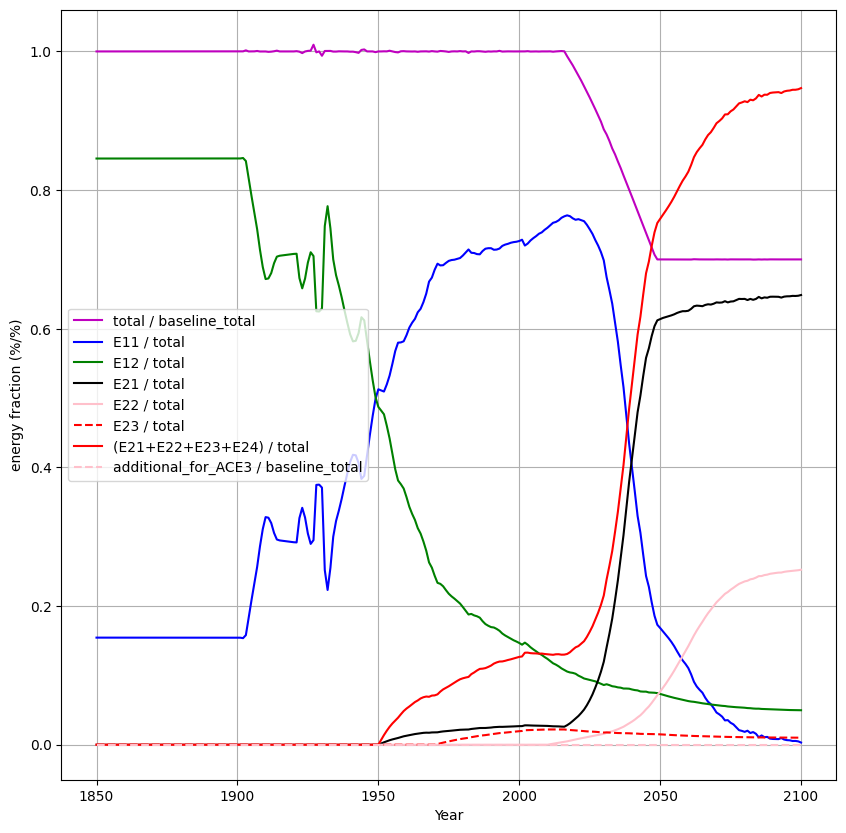

In [14]:
# 绘制图表
fig, ax1 = plt.subplots(figsize=(10, 10))

# 插值处理
E11_all_interp = np.interp(time, time_ode, E11_all)
energy_MYadjusted18502100_total_plus_B3B_plus_ACE3_interp = np.interp(time, time_ode, energy_MYadjusted18502100_total_plus_B3B_plus_ACE3)

# 绘制能量比例
ax1.plot(time, energy_MYadjusted18502100_total_plus_B3B_plus_ACE3_interp / energy_MYbaseline18502100_total, label='total / baseline_total', color='m', linestyle='solid')
ax1.plot(time, E11_all_interp / energy_MYadjusted18502100_total_plus_B3B_plus_ACE3_interp, label='E11 / total', color='blue')
ax1.plot(time, E12 / energy_MYadjusted18502100_total_plus_B3B_plus_ACE3_interp, label='E12 / total', color='green')
ax1.plot(time, E21 / energy_MYadjusted18502100_total_plus_B3B_plus_ACE3_interp, label='E21 / total', color='black')
ax1.plot(time, E22 / energy_MYadjusted18502100_total_plus_B3B_plus_ACE3_interp, label='E22 / total', color='pink')
ax1.plot(time, E23 / energy_MYadjusted18502100_total_plus_B3B_plus_ACE3_interp, label='E23 / total', color='red', linestyle='dashed')
ax1.plot(time, (E21 + E22 + E23 + E24) / energy_MYadjusted18502100_total_plus_B3B_plus_ACE3_interp, label='(E21+E22+E23+E24) / total', color='red')

# 绘制额外的ACE3能量比例
ax1.plot(time, [a / b * 44 / 12 * 10 for a, b in zip(CO2emission_ACE3, energy_MYbaseline18502100_total)], linestyle='dashed', label='additional_for_ACE3 / baseline_total', color='pink')

# 设置图表属性
ax1.grid()
ax1.set_xlabel('Year')
ax1.set_ylabel('energy fraction (%/%)')
ax1.legend()
plt.show()


#### PE 部分汇报

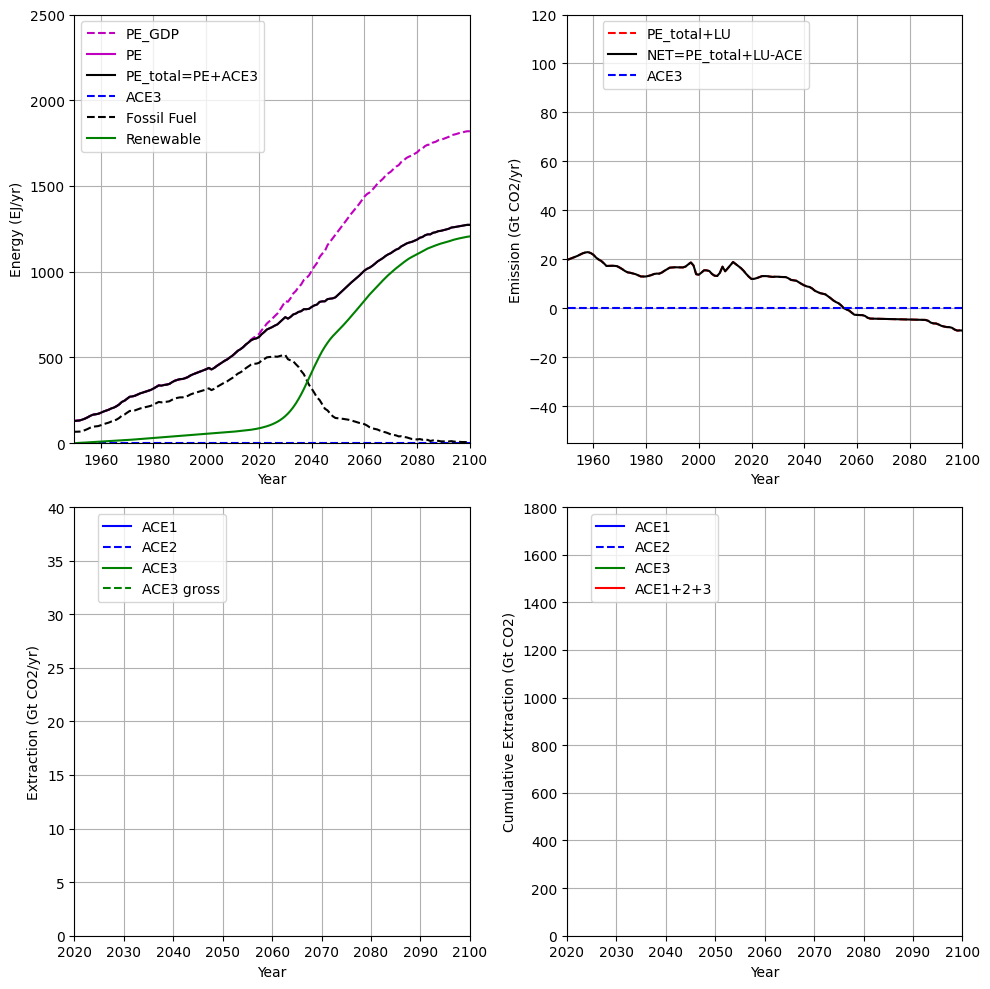

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# 创建 2x2 子图
fig, ([ax2, ax3], [ax4, ax5]) = plt.subplots(2, 2, figsize=(10, 10))

# 插值处理，因为 time 和 ode 里面的 t 不匹配
energy_MYadjusted18502100_total_interp = np.interp(time, time_ode, energy_MYadjusted18502100_total)
energy_MYadjusted18502100_total_plus_B3B_interp = np.interp(time, time_ode, energy_MYadjusted18502100_total_plus_B3B)
CO2emission_actual_interp = np.interp(time, time_ode, CO2emission_actual)
CO2emission_addl_ACE3_FF_injustice_interp = np.interp(time, time_ode, CO2emission_addl_ACE3_FF_injustice)

# 绘制能源数据
ax2.plot(time, energy_MYbaseline18502100_total, label='PE_GDP', color='m', linestyle='dashed')
ax2.plot(time, energy_MYadjusted18502100_total_interp, label='PE', color='m', linestyle='solid')
ax2.plot(time, energy_MYadjusted18502100_total_plus_B3B_plus_ACE3_interp, label='PE_total=PE+ACE3', color='black', linestyle='solid')
ax2.plot(time, [a - b for a, b in zip(energy_MYadjusted18502100_total_plus_B3B_plus_ACE3_interp, energy_MYadjusted18502100_total_plus_B3B_interp)], label='ACE3', color='blue', linestyle='dashed')
ax2.plot(time, E11_all_interp, label='Fossil Fuel', color='black', linestyle='dashed')
ax2.plot(time, E21 + E22 + E23 + E24, label='Renewable', color='green', linestyle='solid')
ax2.grid()
ax2.set_xlabel('Year')
ax2.set_ylabel('Energy (EJ/yr)')
ax2.legend()
ax2.set_xlim([1950, 2100])
ax2.set_ylim([0, 2500])

# 绘制排放数据
ax3.plot(time, [x * 44 / 12 for x in CO2emission_actual_interp], label='PE_total+LU', color='red', linestyle='dashed')
ax3.plot(time, [(a - b - c - d / e) * 44 / 12 for a, b, c, d, e in zip(CO2emission_actual_interp, CO2emission_ACE1, CO2emission_ACE2, CO2emission_ACE3, ratio_net_over_gross)], label='NET=PE_total+LU-ACE', color='black', linestyle='solid')
# ax3.plot(time, [x * 44 / 12 for x in CO2emission_GE_FF], label='PE_GDP', color='black', linestyle='dashed')
ax3.plot(time, [x * 44 / 12 for x in CO2emission_addl_ACE3_FF_injustice_interp], label='ACE3', color='blue', linestyle='dashed')
ax3.grid()
ax3.set_xlabel('Year')
ax3.set_ylabel('Emission (Gt CO2/yr)')
ax3.legend(bbox_to_anchor=(0.63, 1.0))
ax3.set_xlim([1950, 2100])
ax3.set_ylim([-55, 120])

# # 绘制 ACE 排放数据
# ax4.plot(time, [x * 44 / 12 for x in CO2emission_ACE1], label='ACE1', color='blue')
# ax4.plot(time, [x * 44 / 12 for x in CO2emission_ACE2], label='ACE2', color='blue', linestyle='dashed')
# ax4.plot(time, [x * 44 / 12 for x in CO2emission_ACE3], label='ACE3', color='green')
# ax4.plot(time, [x / y * 44 / 12 for x, y in zip(CO2emission_ACE3, ratio_net_over_gross)], label='ACE3 gross', color='green', linestyle='dashed')
# 在 ax4 中绘制 ACE 的相关图例，不绘制数据
ax4.plot(time, label='ACE1', color='blue')
ax4.plot(time, label='ACE2', color='blue', linestyle='dashed')
ax4.plot(time, label='ACE3', color='green')
ax4.plot(time, label='ACE3 gross', color='green', linestyle='dashed')


ax4.grid()
ax4.set_xlabel('Year')
ax4.set_ylabel('Extraction (Gt CO2/yr)')
ax4.legend(bbox_to_anchor=(0.4, 1.0))
ax4.set_xlim([2020, 2100])
ax4.set_ylim([0, 40])



# 绘制 ACE 累计排放数据
# ax5.plot(time, np.cumsum(CO2emission_ACE1) * 44 / 12, label='ACE1', color='blue')
# ax5.plot(time, np.cumsum(CO2emission_ACE2) * 44 / 12, label='ACE2', color='blue', linestyle='dashed')
# ax5.plot(time, np.cumsum(CO2emission_ACE3) * 44 / 12, label='ACE3', color='green')

# ax5.plot(time, [a + b + c for a, b, c in zip(np.cumsum(CO2emission_ACE1) * 44 / 12, np.cumsum(CO2emission_ACE2) * 44 / 12, np.cumsum(CO2emission_ACE3) * 44 / 12)], label='ACE1+2+3', color='red', linestyle='solid')

ax5.plot(time, label='ACE1', color='blue')
ax5.plot(time, label='ACE2', color='blue', linestyle='dashed')
ax5.plot(time, label='ACE3', color='green')

ax5.plot(time, label='ACE1+2+3', color='red', linestyle='solid')


ax5.grid()
ax5.set_xlabel('Year')
ax5.set_ylabel('Cumulative Extraction (Gt CO2)')
ax5.legend(bbox_to_anchor=(0.4, 1.0))
ax5.set_xlim([2020, 2100])
ax5.set_ylim([0, 1800])

plt.tight_layout()
plt.show()


#### 模型细节变量-tao 部分

(0.0, 25.0)

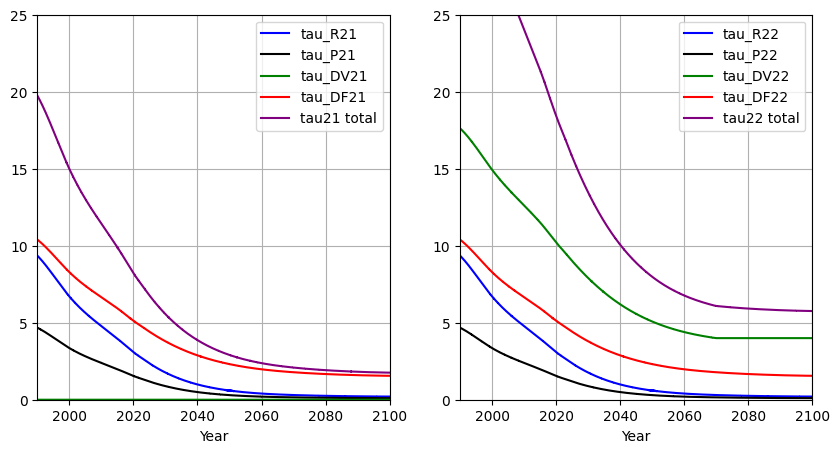

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))


ax1.plot(time_ode, taoR21, 'blue', label='tau_R21')
ax1.plot(time_ode, taoP21, 'black', label='tau_P21')
ax1.plot(time_ode, taoDV21, 'green', label='tau_DV21')
ax1.plot(time_ode, taoDF21, 'red', label='tau_DF21')
ax1.plot(time_ode, tao21, 'purple', label='tau21 total')
ax1.set_xlabel('Year')
ax1.legend()
ax1.grid()
ax1.set_xlim((1990,2100))
ax1.set_ylim((0,25))
ax2.plot(time_ode, taoR22, 'blue', label='tau_R22')
ax2.plot(time_ode, taoP22, 'black', label='tau_P22')
ax2.plot(time_ode, taoDV22, 'green', label='tau_DV22')
ax2.plot(time_ode, taoDF22, 'red', label='tau_DF22')
ax2.plot(time_ode, tao22, 'purple', label='tau22 total')
ax2.set_xlabel('Year')
ax2.legend()
ax2.grid()
ax2.set_xlim((1990,2100))
ax2.set_ylim((0,25))




## 绘制部分-验证篇

这里主要说明模型的可靠度，考虑使用真实的数据对比说明

### 温度

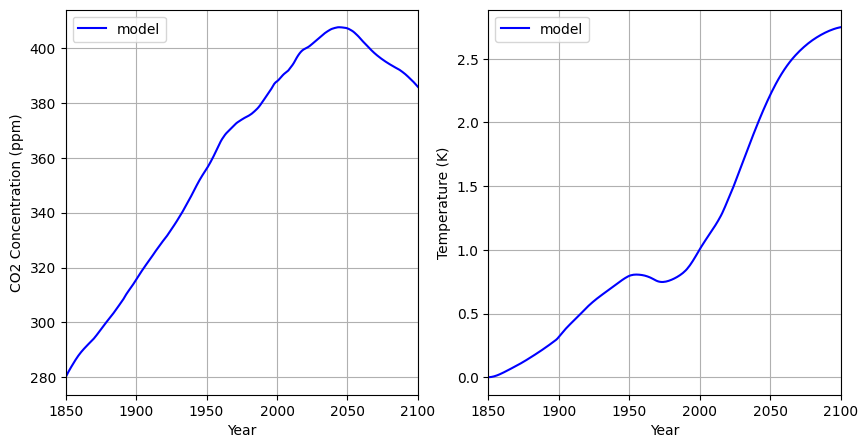

In [ ]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
## C_a needs to *rho_a to convert Gt to ppm

ax1.plot(time, C_a*rho_a, 'blue', label='model')
ax1.set_ylabel('CO2 Concentration (ppm)')
ax1.set_xlabel('Year')
# ax1.plot(CO2.year,CO2.co2,'black',label='observed')
# TODO 缺少未来真实的数据对比操作
# 原文中的数据是：
# CO2 = pd.read_excel('../data/input/spline_merged_ice_core_yearly.xlsx',sheet_name = 'Sheet1')

ax1.grid()
ax1.set_xlim((1850,2100))
#ax1.set_ylim((300,800))
#temperature of atomosphere for 4 cases
ax2.plot(time, T_a, 'blue', label='model')
# ax2.plot(temp.iloc[1:-1,0].astype('int'),temp.iloc[1:-1,13].astype('float') + diff ,'black',label = 'observed')
# TODO 缺少未来真实的数据对比操作
# 原文中的数据是：
# temp = pd.read_csv('../data/input/GLB.Ts+dSST.xlsx') #  下载文献中有相关的数据

ax2.set_xlabel('Year')
ax2.set_ylabel('Temperature (K)')
ax2.grid()
ax2.set_xlim((1850,2100))
#ax2.set_ylim((-0.2,2.0))

ax1.legend()
ax2.legend()



下面是 iseec 原文中的图片内容

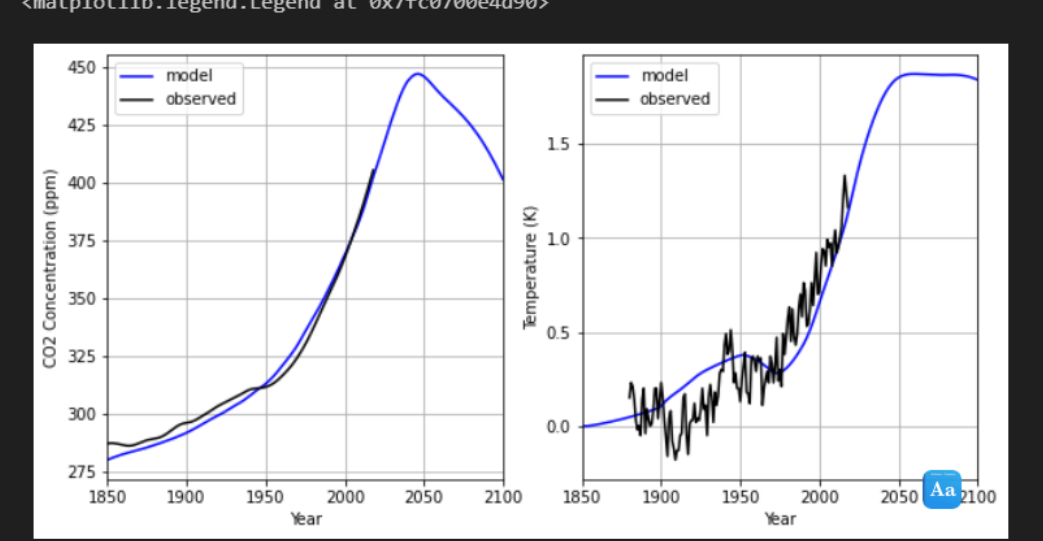